<a href="https://colab.research.google.com/github/tbeucler/2023_MOOC_ECMWF/blob/main/Physically_informed_parameterization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 2: Physically-Informed Parameterization

⛈ Welcome to the second exercise of the "Physics-Guided Machine Learning" e-learning module of ECMWF's MOOC on Machine Learning in Weather and Climate 🌤

By the end of this second exercise, you will:

1.   Understand how using physical knowledge to rescale a machine learning model's inputs can make it more robust and generalizable,
2.   Know how to use *custom data generators* to nonlinearly rescale inputs before feeding them to a neural network, and
3.   Practice what you will learn about parameterization in Tier 3 on a realistic research case. 

While this notebook's completion time may widely vary depending on your programming experience, we estimate it will average to 30 minutes for this MOOC's students. This notebook provides a minimal reproducible example of the work described in the following preprint:

[Beucler, Tom, Michael Pritchard, Janni Yuval, Ankitesh Gupta, Liran Peng, Stephan Rasp, Fiaz Ahmed et al. "Climate-invariant machine learning."](https://arxiv.org/abs/2112.08440), 

and contains a reduced version of our data.

We will be relying on Keras, whose documentation you can find [here](https://keras.io/), and TensorFlow, whose documentation you can find [here](https://www.tensorflow.org/). The notebooks assume that you will run them on Google Colab (Google Colab tutorial [at this link](https://colab.research.google.com/drive/16pBJQePbqkz3QFV54L4NIkOn1kwpuRrj)). 

While everything can be run locally and there are only a handful of lines that use Google specific libraries, we encourage beginners to use Google Colab not to run into [Python virtual environment](https://docs.python.org/3/tutorial/venv.html) issues. 

Before we get started, if you are struggling with some of the exercises, do not hesitate to:


*   Use a direct Internet search, or [stackoverflow](https://stackoverflow.com/)
*   Debug your program, e.g. by following [this tutorial](https://swcarpentry.github.io/python-novice-inflammation/11-debugging/index.html)
*   Use assertions, e.g. by following [this tutorial](https://swcarpentry.github.io/python-novice-inflammation/10-defensive/index.html)
*   Ask for help on the MOOC's Moodle Forum

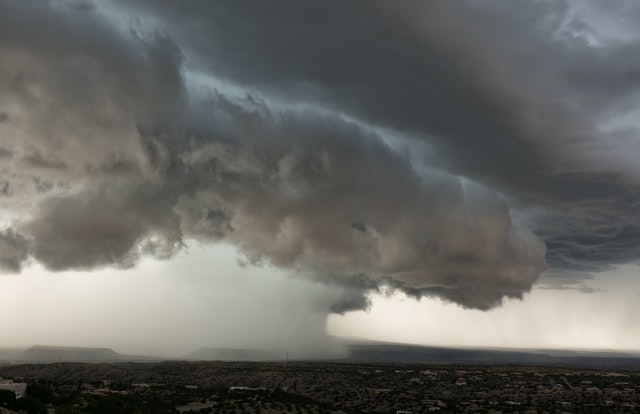

Storms rapidly transport heat and water in the atmosphere, regulating the Earth's climate. Can you predict how storms affect atmospheric temperatures using deep learning, even in a changing climate?

*Source: Photo by <a href="https://unsplash.com/@wildhoney?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">John Fowler</a> licensed under the <a href='https://unsplash.com/license'>Unsplash License.</a>*

## Part I: Configuration and Requirements

In [1]:
!pip install --no-binary 'shapely==1.6.4' 'shapely==1.6.4' --force
!pip install cartopy # Install latest version of cartopy
!pip install xarray # Install latest version of xarray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Shapely-1.6.4-py2.py3-none-any.whl
  Attempting uninstall: shapely
    Found existing installation: Shapely 1.6.4
    Uninstalling Shapely-1.6.4:
      Successfully uninstalled Shapely-1.6.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import pooch
import xarray as xr

In [17]:
path_data = 'https://unils-my.sharepoint.com/:u:/g/personal/tom_beucler_unil_ch/'
path_cold = path_data + 'EfHoI_pZY3xAi4bLEuDobaUBjyQmoJd1AvYnoPdH01VN-w?download=1'
path_warm = path_data + 'Eeq_n6Qv0jZBuRkICaOb0VQB6J1cN7muM6MrA3zA-v7LFg?download=1'
cold_open = pooch.retrieve(path_cold,known_hash='7b793afdd866a2e9b0db8fdb5029a88d557bf98525601275f5a335e95b26ac1a')
warm_open = pooch.retrieve(path_warm,known_hash='211db8ae89904f1fa3e2f17dc623bc6f5c6156cf24f4e3a42d92660ab1790fd4')
cold_data = xr.open_dataset(cold_open)
warm_data = xr.open_dataset(warm_open)

# Extract the range of possible longitude and latitude in case of need 
longitude = cold_data.lon[:144].values
latitude = cold_data.lat[:96*144:144].values
# SPCAM's background pressure coordinates (in hPa)
pressure_levels = np.array([ 3.643466, 7.59482 , 14.356632, 24.61222 ,
                            38.2683  , 54.59548 , 72.012451,  87.82123 ,
                            103.317127, 121.547241, 142.994039, 168.22508 ,
                            197.908087, 232.828619, 273.910817, 322.241902,
                            379.100904, 445.992574, 524.687175, 609.778695,
                            691.38943 , 763.404481, 820.858369, 859.534767,
                            887.020249, 912.644547, 936.198398, 957.48548 ,
                            976.325407, 992.556095])

In [4]:
# Set the default fontsize and linewidth of your plots here
fz = 12 # Recommended fontsize value = 12
lw = 4 # Recommended linewidth value = 4

In [5]:
plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw

## Part II: Pre-Processing the Dataset for Regression

Just in case you need it, we've extracted all possible latitude values in `latitude` and all possible longitude values in `longitude`. 

In [42]:
cold_data['vars']

<xarray.DataArray 'vars' (sample: 2398208, var_names: 184)>
[441270272 values with dtype=float32]
Coordinates:
  * var_names  (var_names) object 'QBP' 'QBP' 'QBP' 'QBP' ... 'QRS' 'QRS' 'QRS'
    time       (sample) int64 ...
    lat        (sample) float64 ...
    lon        (sample) float64 0.0 2.5 5.0 7.5 10.0 ... 70.0 72.5 75.0 77.5
Dimensions without coordinates: sample

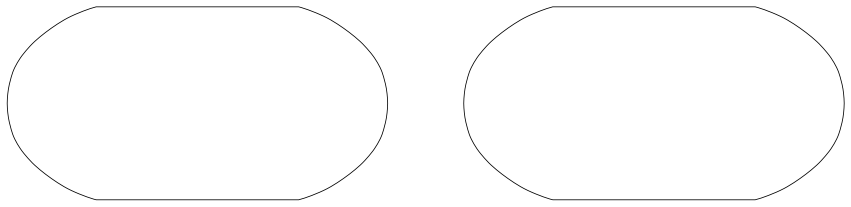

In [38]:
fig, ax = plt.subplots(1,2,
                       subplot_kw={'projection':ccrs.Robinson(central_longitude=180)},
                       figsize=(15,5))

cold = ax[0].pcolormesh(data_col)

## Part III: Training and Testing an Artificial Neural Network

## Part IV: Physically Rescaling the Inputs to Facilitate Generalization

## Part V: Towards "Climate-Invariant" Neural Networks

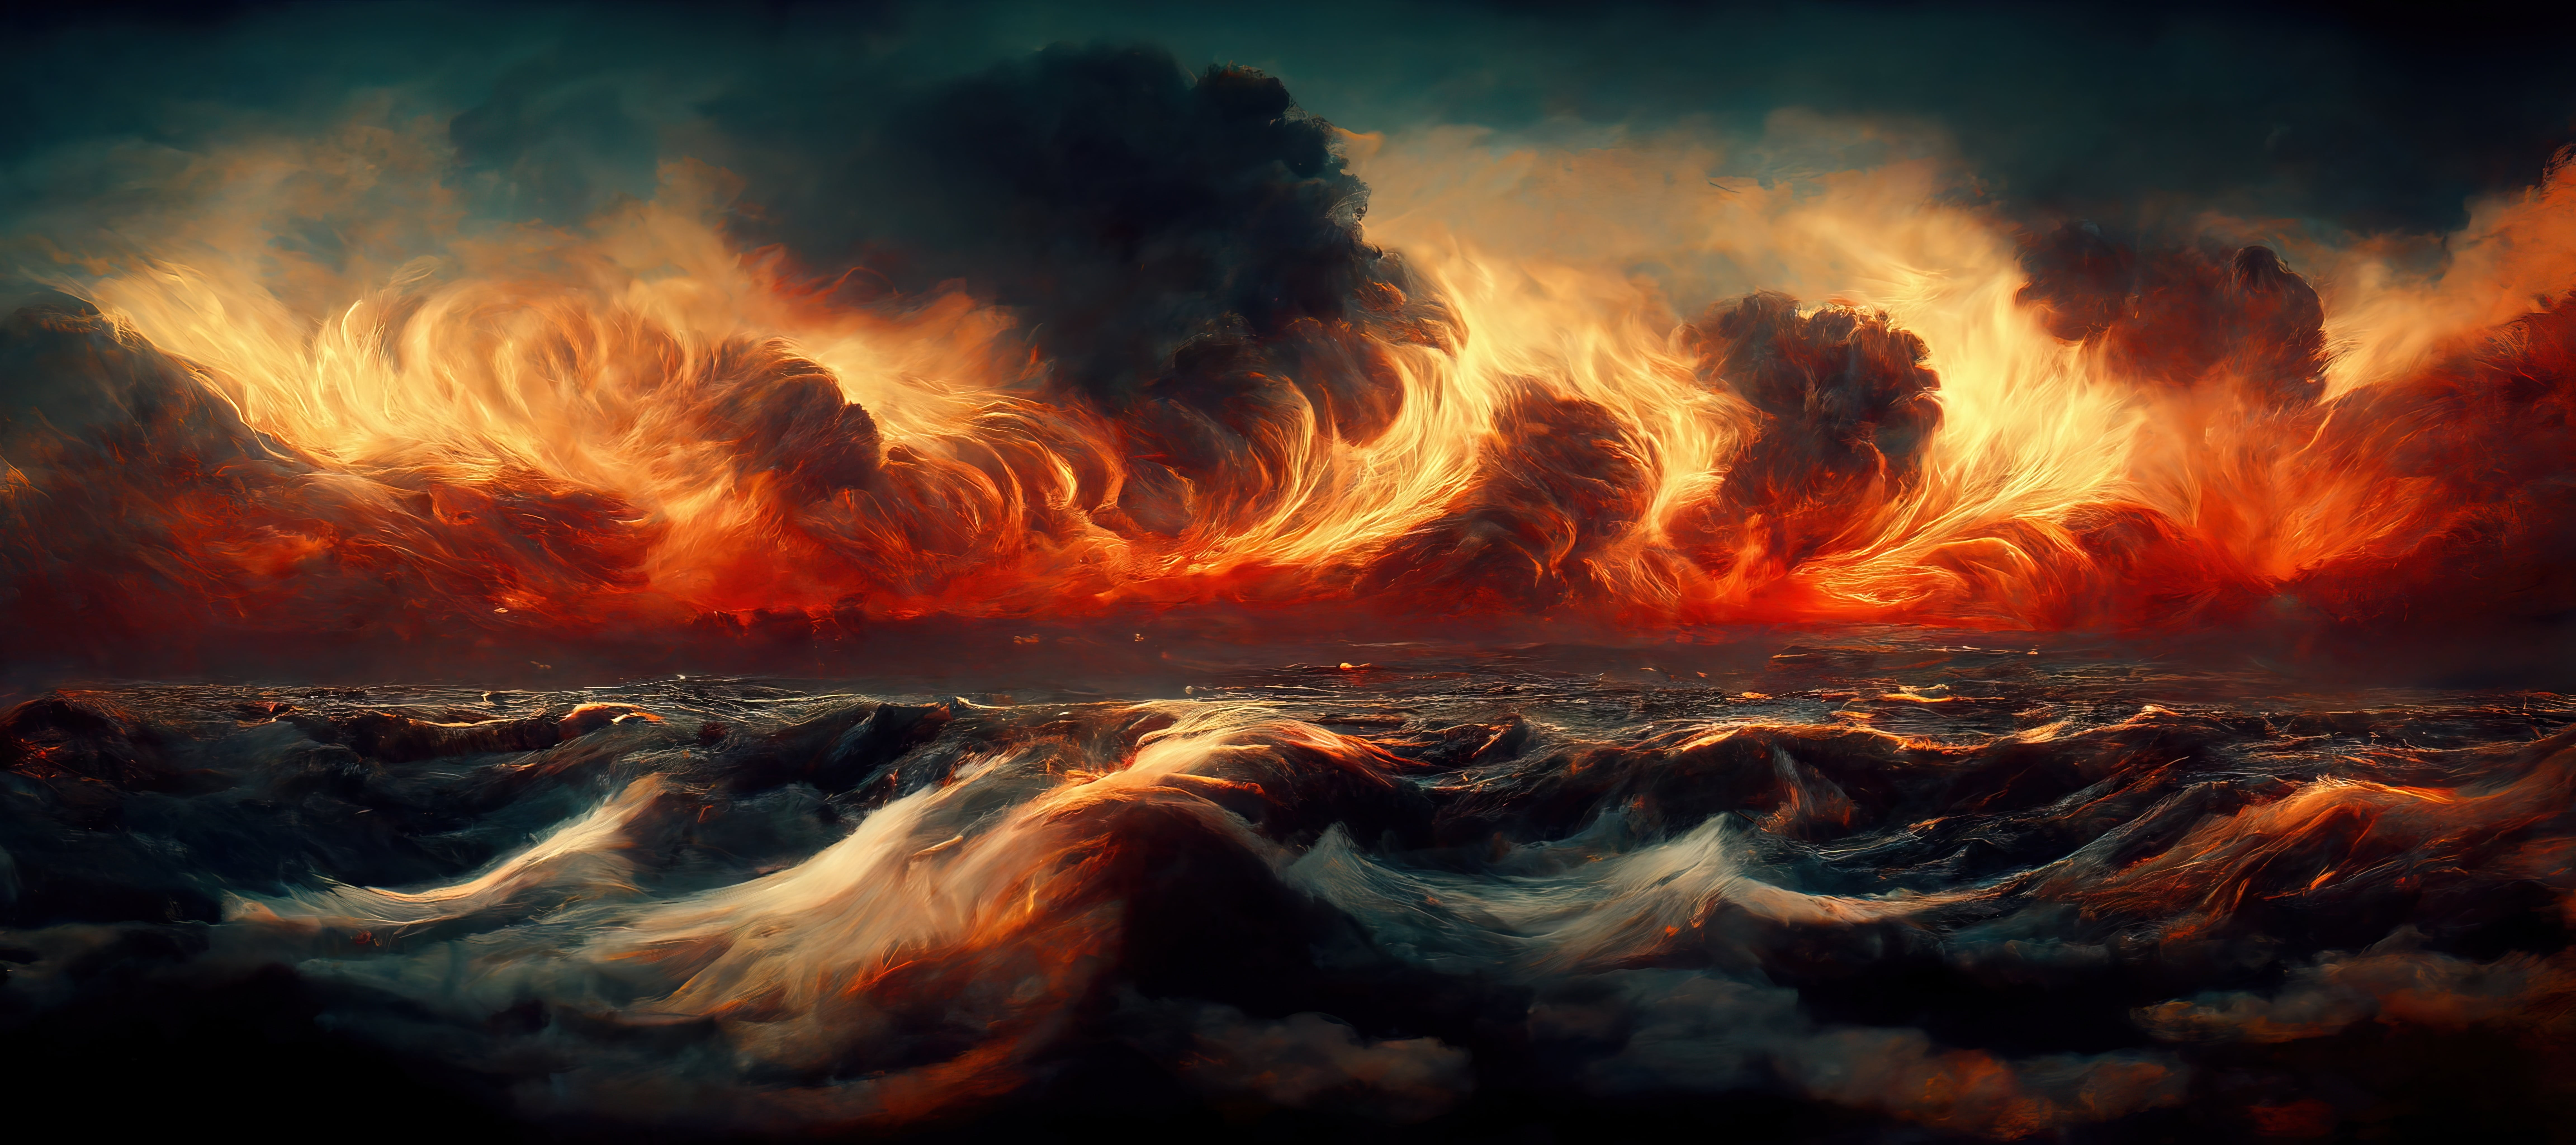

🔥 Congratulations: You can now use your physical knowledge to create machine learning algorithms that are robust to changes in their inputs!

And with that, you are officially done with the exercises of Tier 2: Well-done 🎉

*Source: Art by [SoulMyst](https://stock.adobe.com/ch_de/contributor/210533293/soulmyst?load_type=author&prev_url=detail) licensed under the [Adobe Stock standard license](https://stock.adobe.com/license-terms)* 